In [30]:
from utils import sig, sigfit, TwoFlashesProcessingStrategy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Data preparation

In [39]:
# Load data
df = pd.read_csv("DFI_SPQ_Data.csv")
data = pd.melt(df, value_name="Flashes", var_name="Delay", id_vars=["ID", "Group"])
data["Flashes"] = (data["Flashes"] / 10) * 100
data.rename(columns={"Flashes": "Flashes (%)", "Delay": "SOA"}, inplace=True)
data["SOA"] = data.SOA.astype(float)

# Average data by group
avg_data = data.groupby(["Group", "SOA"])["Flashes (%)"].aggregate(["mean", "sem"])
avg_data.reset_index(inplace=True)
avg_data.rename(
    columns={"mean": "Flashes (%)", "sem": "Flashes (%) - sem"}, inplace=True
)
avg_data.sort_values("SOA", inplace=True)

soas = avg_data.SOA.unique()

In [40]:
hspq_raw_data = avg_data.query("Group == 'H-SPQ' ")["Flashes (%)"].values
lspq_raw_data = avg_data.query("Group == 'L-SPQ' ")["Flashes (%)"].values

hspq_a, hspq_b, hspq_c, hspq_d = sigfit(soas, hspq_raw_data)
lspq_a, lspq_b, lspq_c, lspq_d = sigfit(soas, lspq_raw_data)

print("H-SPQ:", hspq_a, hspq_b, hspq_c, hspq_d)
print("L-SPQ:", lspq_a, lspq_b, lspq_c, lspq_d)

H-SPQ: 13.05408294897488 65.5401325697481 85.57693995059172 -30.097847882138687
L-SPQ: 15.045053078605632 66.71037671456425 59.806102985973936 -26.553131464961037


In [41]:
# Fit group data to sigmoid
for group in avg_data.groupby("Group"):
    if group[0] == "H-SPQ":
        group[1]["Fit"] = sig(x=group[1]["SOA"], a=hspq_a, b=hspq_b, c=hspq_c, d=hspq_d)
        df_hspq = group[1]
    elif group[0] == "L-SPQ":
        group[1]["Fit"] = sig(x=group[1]["SOA"], a=lspq_a, b=lspq_b, c=lspq_c, d=lspq_d)
        df_lspq = group[1]

dataset = pd.concat([df_hspq, df_lspq])
dataset.head()

,Group,SOA,Flashes (%),Flashes (%) - sem,Fit
0,H-SPQ,36.0,68.214286,5.321753,68.010219
1,H-SPQ,48.0,62.857143,6.082700,63.981310
2,H-SPQ,60.0,60.714286,5.514017,58.966500
3,H-SPQ,72.0,52.142857,5.451982,53.092495
4,H-SPQ,84.0,48.571429,5.532833,46.682427


## Model run

In [42]:
from skneuromsi.neural import Paredes2022
from skneuromsi.sweep import ParameterSweep


def two_flashes_job(a_tau, v_tau, m_tau, cm_weight, fb_weight, ff_weight, l_ex):

    model = Paredes2022(
        time_range=(0, 550),
        neurons=30,
        position_range=(0, 30),
        tau=(a_tau, v_tau, m_tau),
    )

    sp = ParameterSweep(
        model=model,
        target="auditory_soa",
        repeat=1,
        n_jobs=10,
        range=soas,
        processing_strategy=TwoFlashesProcessingStrategy(),
    )

    res = sp.run(
        auditory_intensity=2.325,
        visual_intensity=1.45,
        auditory_stim_n=2,
        visual_stim_n=1,
        auditory_duration=7,
        visual_duration=12,
        noise=False,
        lateral_excitation=l_ex,
        lateral_inhibition=0.4,
        cross_modal_weight=cm_weight,
        feedback_weight=fb_weight,
        feedforward_weight=ff_weight,
    )

    return res


lspq_raw_model_data = two_flashes_job(
    a_tau=6.560e00,
    v_tau=9.191e00,
    m_tau=1.200e02,
    cm_weight=1.036e-03,
    fb_weight=6.231e-01,
    ff_weight=3.892e00,
    l_ex=0.5,
)

alter_lspq_raw_model_data = two_flashes_job(
    a_tau=1.981e01,
    v_tau=2.559e01,
    m_tau=6,
    cm_weight=4.928e-02,
    fb_weight=0,
    ff_weight=0,
    l_ex=0.5,
)

hspq_raw_model_data = two_flashes_job(
    a_tau=6.560e00,
    v_tau=9.191e00,
    m_tau=1.200e02,
    cm_weight=1.036e-03,
    fb_weight=6.231e-01,
    ff_weight=3.892e00,
    l_ex=5.305e-01,
)

# alter_hspq_raw_model_data = two_flashes_job(
#    a_tau=6.560e00,
#    v_tau=9.191e00,
#    m_tau=1.200e02,
#    cm_weight=3.995e-02,
#    fb_weight=6.231e-01,
#    ff_weight=3.892e00,
#    l_ex=0.5,
# )

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

## Sigmoid fitting of model results

In [43]:
model_hspq_a, model_hspq_b, model_hspq_c, model_hspq_d = sigfit(
    soas, hspq_raw_model_data
)
# alter_model_hspq_a, alter_model_hspq_b, alter_model_hspq_c, alter_model_hspq_d = sigfit(
#    soas, alter_hspq_raw_model_data
# )
model_lspq_a, model_lspq_b, model_lspq_c, model_lspq_d = sigfit(
    soas, lspq_raw_model_data
)

alter_model_lspq_a, alter_model_lspq_b, alter_model_lspq_c, alter_model_lspq_d = sigfit(
    soas, alter_lspq_raw_model_data
)

data_twi = [
    [
        "L-SPQ",
        "Model",
        model_lspq_c,
    ],
    ["L-SPQ", "Data", lspq_c],
    [
        "H-SPQ",
        "Model",
        model_hspq_c,
    ],
    ["H-SPQ", "Data", hspq_c],
]

df_twi = pd.DataFrame(data=data_twi, columns=["Group", "Data", "TWI (ms)"])
df_twi

,Group,Data,TWI (ms)
0,L-SPQ,Model,67.038426
1,L-SPQ,Data,59.806103
2,H-SPQ,Model,98.656710
3,H-SPQ,Data,85.576940


In [44]:
# Compute TWI individually and get average and sem
df_fit = pd.DataFrame(columns=["Group", "ID", "a", "b", "TWI (ms)", "d"])

for group in data.groupby("Group"):
    for participant in group[1].groupby("ID"):
        a, b, c, d = sigfit(soas, participant[1]["Flashes (%)"])
        df_fit.loc[len(df_fit.index)] = [group[0], participant[0], a, b, c, d]

df_fit.sort_values("Group", ascending=False, inplace=True)

## Figure 4

In [45]:
import seaborn as sns

sns.set_context("paper")
sns.set_theme(
    style="ticks",
    palette=["black", "grey", "grey"],
    rc={"axes.labelsize": 12, "axes.labelweight": "bold"},
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


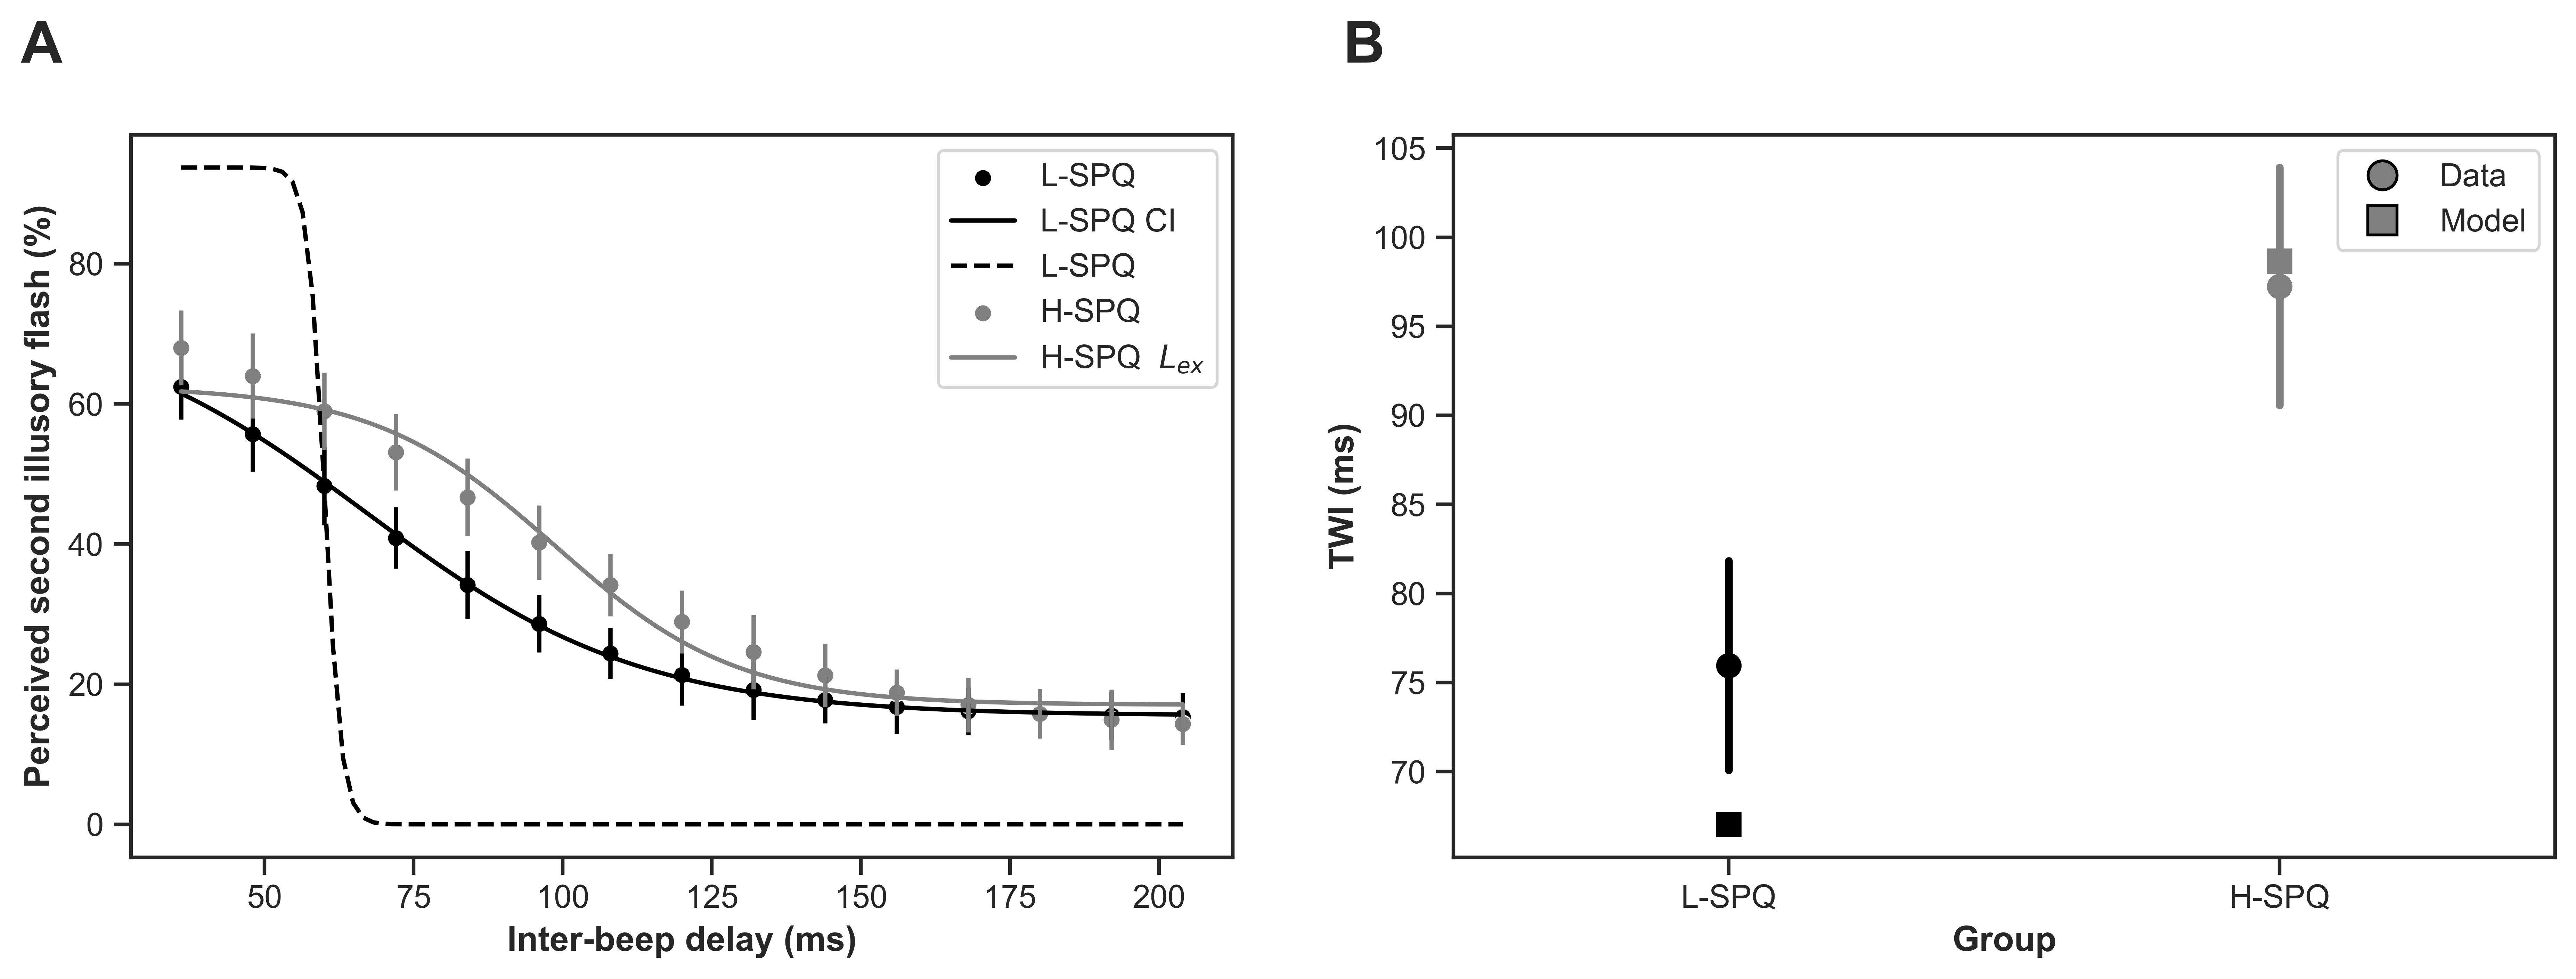

In [46]:
import string
import matplotlib.lines as mlines

model_soas = np.linspace(soas[0], soas[-1], 100)
hspq_model_data = sig(
    model_soas, model_hspq_a, model_hspq_b, model_hspq_c, model_hspq_d
)
# alter_hspq_model_data = sig(
#    model_soas,
#    alter_model_hspq_a,
#    alter_model_hspq_b,
#    alter_model_hspq_c,
#    alter_model_hspq_d,
# )
lspq_model_data = sig(
    model_soas, model_lspq_a, model_lspq_b, model_lspq_c, model_lspq_d
)

alter_lspq_model_data = sig(
    model_soas,
    alter_model_lspq_a,
    alter_model_lspq_b,
    alter_model_lspq_c,
    alter_model_lspq_d,
)

lspq_data = dataset.query("Group == 'L-SPQ' ").sort_values("SOA").Fit.values
hspq_data = dataset.query("Group == 'H-SPQ' ").sort_values("SOA").Fit.values

lspq_data_err = (
    dataset.query("Group == 'L-SPQ' ").sort_values("SOA")["Flashes (%) - sem"].values
)
hspq_data_err = (
    dataset.query("Group == 'H-SPQ' ").sort_values("SOA")["Flashes (%) - sem"].values
)

fig, axs = plt.subplots(1, 2, figsize=(15, 4.5), dpi=600)
ax1 = plt.subplot(121)

sns.scatterplot(x=soas, y=lspq_data, label="L-SPQ", ax=ax1)
ax1.errorbar(x=soas, y=lspq_data, yerr=lspq_data_err, fmt="none", color="black")
sns.lineplot(x=model_soas, y=lspq_model_data, label="L-SPQ CI", ax=ax1)
sns.lineplot(
    x=model_soas,
    y=alter_lspq_model_data,
    label="L-SPQ",
    ax=ax1,
    linestyle="--",
    color="black",
)
sns.scatterplot(x=soas, y=hspq_data, label="H-SPQ", ax=ax1)
ax1.errorbar(x=soas, y=hspq_data, yerr=hspq_data_err, fmt="none", color="gray")
sns.lineplot(x=model_soas, y=hspq_model_data, label="H-SPQ  $L_{ex}$", ax=ax1)
# sns.lineplot(
#    x=model_soas,
#    y=alter_hspq_model_data,
#    label="H-SPQ $W_{av,va}$",
#    ax=ax1,
#    linestyle="--",
# )

ax1.set_xlabel("Inter-beep delay (ms)")
ax1.set_ylabel("Perceived second illusory flash (%)")
ax1.text(
    -0.1,
    1.1,
    string.ascii_uppercase[0],
    transform=ax1.transAxes,
    size=20,
    weight="bold",
)

ax2 = plt.subplot(122)
sns.pointplot(
    x="Group",
    y="TWI (ms)",
    data=df_fit,
    join=False,
    errorbar="se",
    ax=ax2,
    label="Data",
    palette=["black", "gray"],
)
sns.pointplot(
    x=["L-SPQ", "H-SPQ"],
    y=[model_lspq_c, model_hspq_c],
    join=False,
    ax=ax2,
    label="Model",
    markers="s",
    palette=["black", "gray"],
)
ax2.text(
    -0.1,
    1.1,
    string.ascii_uppercase[1],
    transform=ax2.transAxes,
    size=20,
    weight="bold",
)

circle = mlines.Line2D(
    [],
    [],
    marker="o",
    linestyle="None",
    markersize=10,
    label="Data",
    markerfacecolor="gray",
    markeredgecolor="black",
)
square = mlines.Line2D(
    [],
    [],
    marker="s",
    linestyle="None",
    markersize=10,
    label="Model",
    markerfacecolor="gray",
    markeredgecolor="black",
)
ax2.legend(handles=[circle, square])

fig.savefig("drafts/FIG4.eps", bbox_inches="tight", format="eps")